In [18]:
import glob
from dataclasses import dataclass
from typing import Tuple, List, Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from lib import parametrization as par
from lib import work_dir

%matplotlib inline
sns.set(font_scale=1.75)
color_map = sns.light_palette("green", as_cmap=True)


@dataclass
class ExperimentArguments:
    language: str
    transformation_name: str
    fuzzing_strategy: str
    subject_name: str


class CoveragePlotter:
    def __init__(self, args: ExperimentArguments):
        self._args = args

    def _create_path_patterns(self) -> Tuple[str, str]:
        shared_prefix = f"{work_dir}/coverage-reports"
        shared_suffix = f"{self._args.fuzzing_strategy}/{self._args.subject_name}"
        after_subdir = f"{self._args.language}/{self._args.transformation_name}"
        before_subdir = f"{self._args.language}/identity"
        after_pattern = f"{shared_prefix}/{after_subdir}/{shared_suffix}/**/coverage.csv"
        before_pattern = f"{shared_prefix}/{before_subdir}/{shared_suffix}/**/coverage.csv"
        return after_pattern, before_pattern

    def _find_matching_paths(self) -> Tuple[List[str], List[str]]:
        after_pattern, before_pattern = self._create_path_patterns()
        after_paths = glob.glob(after_pattern, recursive=True)
        before_paths = glob.glob(before_pattern, recursive=True)
        return after_paths, before_paths

    def _filter_unpaired_paths(self) -> Optional[Tuple[List[str], List[str]]]:
        paths = self._find_matching_paths()
        if not paths:
            return None
        after_paths, before_paths = paths
        all_paths_are_paired = len(after_paths) == len(before_paths)
        if not all_paths_are_paired:
            return None
        return after_paths, before_paths

    def _load_coverages(self) -> Optional[Tuple[List[pd.DataFrame], List[pd.DataFrame]]]:
        paths = self._filter_unpaired_paths()
        if not paths:
            return None
        after_paths, before_paths = paths
        after_coverages = [pd.read_csv(path, usecols=["filenum", "branch"]) for path in after_paths]
        before_coverages = [pd.read_csv(path, usecols=["filenum", "branch"]) for path in before_paths]
        return after_coverages, before_coverages

    def _concat_coverages(self) -> Optional[Tuple[pd.DataFrame, pd.DataFrame]]:
        coverages = self._load_coverages()
        if not coverages:
            return None
        after_coverages, before_coverages = self._load_coverages()
        after_df = pd.concat(after_coverages)
        before_df = pd.concat(before_coverages)
        return after_df, before_df

    def _make_comparison_df(self) -> Optional[pd.DataFrame]:
        dfs = self._concat_coverages()
        if not dfs:
            return None
        after_df, before_df = dfs
        after_df["transformation"] = self._args.transformation_name
        before_df["transformation"] = "identity"
        return pd.concat((after_df, before_df), sort=False, ignore_index=True)

    def _make_title(self):
        return f"Language {self._args.language}, Subject {self._args.subject_name}, Strategy {self._args.fuzzing_strategy}"

    def plot_mean_coverage_comparison(self):
        comparison_df = self._make_comparison_df()
        if comparison_df is None:
            return
        # if not comparison_df:
        #     return
        plt.figure(figsize=(20, 8))
        ax = sns.lineplot(data=comparison_df, x="filenum", y="branch", hue="transformation", style="transformation",
                          dashes=False, ci=95)  # , units="run", estimator=None)
        title = self._make_title()
        ax.set_title(title)
        ax.set_xlabel("Number of Files")
        ax.set_ylabel("Mean Branch Coverage")

    def plot_scatter_coverage_comparison(self):
        comparison_df = self._make_comparison_df()
        if comparison_df is None:
            return
        # if not comparison_df:
        #     return
        plt.figure(figsize=(20, 8))
        ax = sns.scatterplot(data=comparison_df, x="filenum", y="branch", hue="transformation", style="transformation")
        title = self._make_title()
        ax.set_title(title)
        ax.set_xlabel("Number of Files")
        ax.set_ylabel("Branch Coverage")


# TODO could have different views here for transformations, languages etc. to allow for better notebook sectioning
class PlotterParametrization:
    def __init__(self):
        self._args_collection = self._build_arguments()

    def _build_arguments(self):
        for language in par.languages:
            for transformation_name in par.transformations:
                for fuzzing_strategy in par.fuzzing_strategies:
                    for subject in par.subjects[language]:
                        yield ExperimentArguments(language, transformation_name, fuzzing_strategy, subject)

    def parametrize_plotters(self):
        for args in self._args_collection:
            yield CoveragePlotter(args)


parametrization = PlotterParametrization()
plotters = parametrization.parametrize_plotters()
# config = ExperimentArguments("json", "chomsky-normal-form", "recurrent-2-path-100", "argo")
# plotter = CoveragePlotter(config)


C:\Users\schue\AppData\Local\Temp/ipykernel_1636/696016925.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 8))


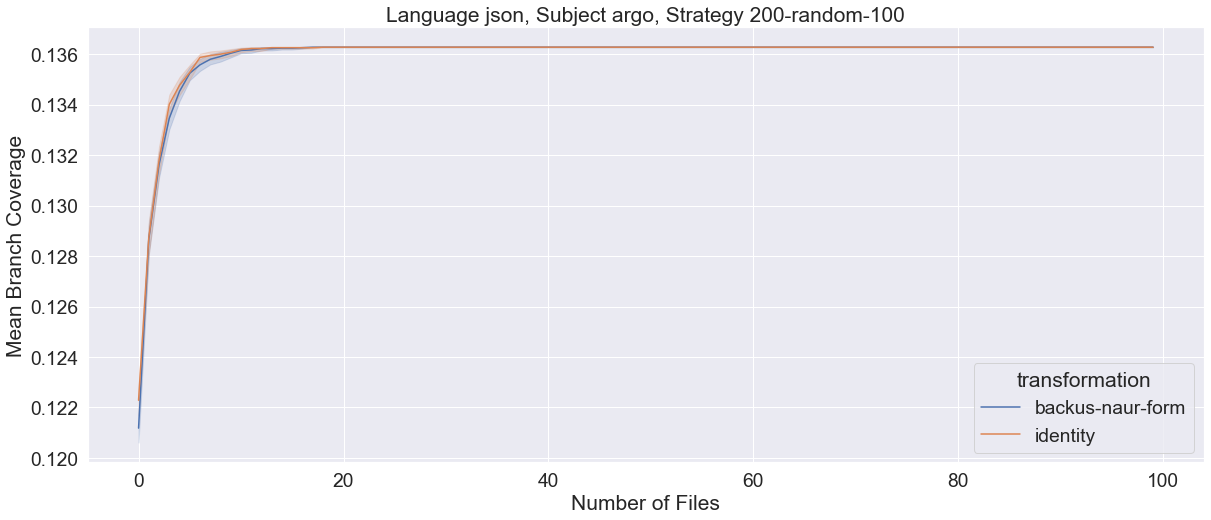

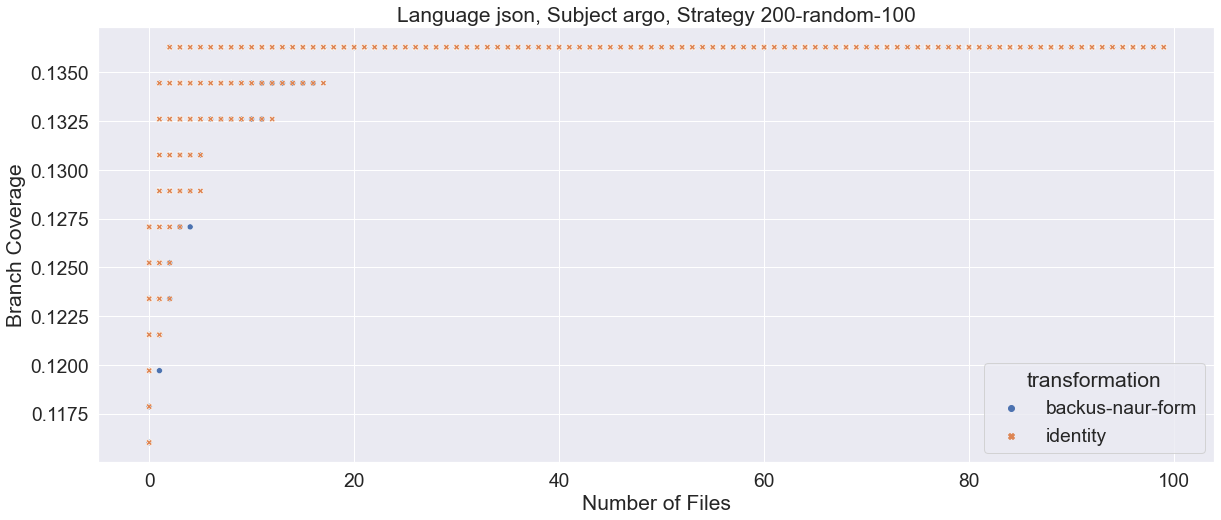

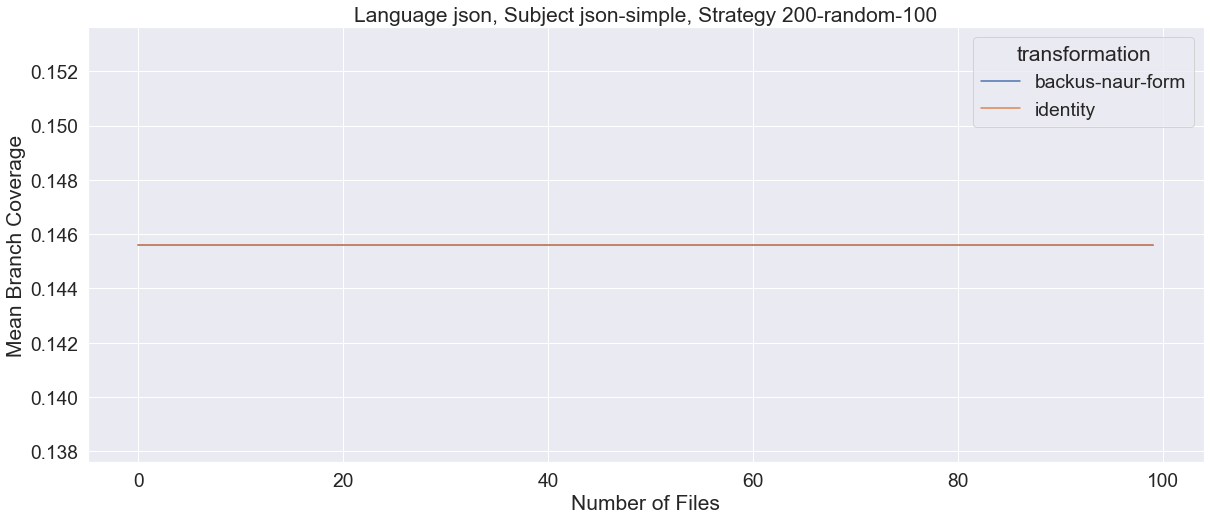

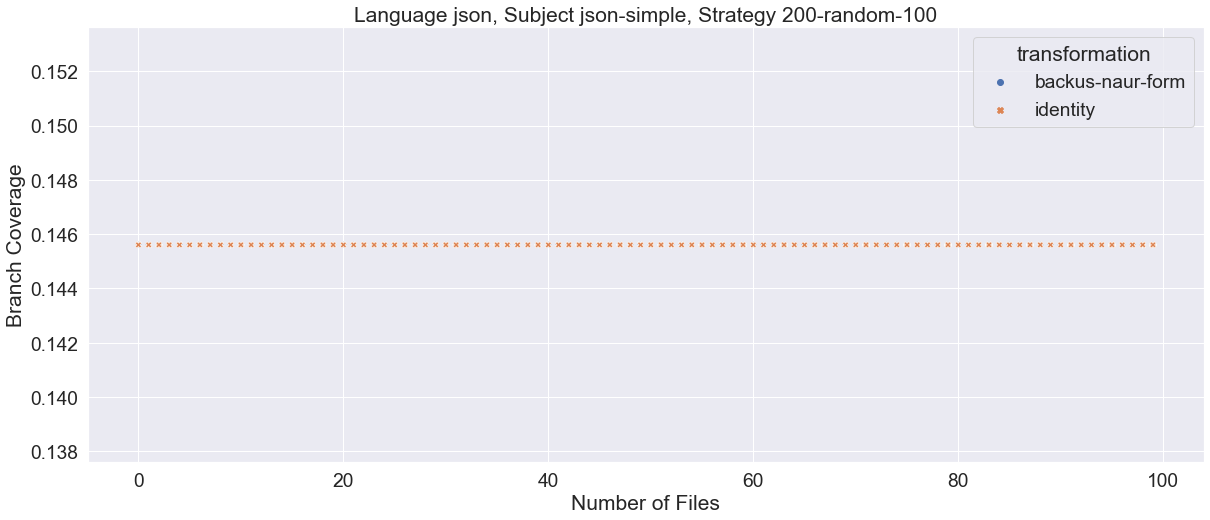

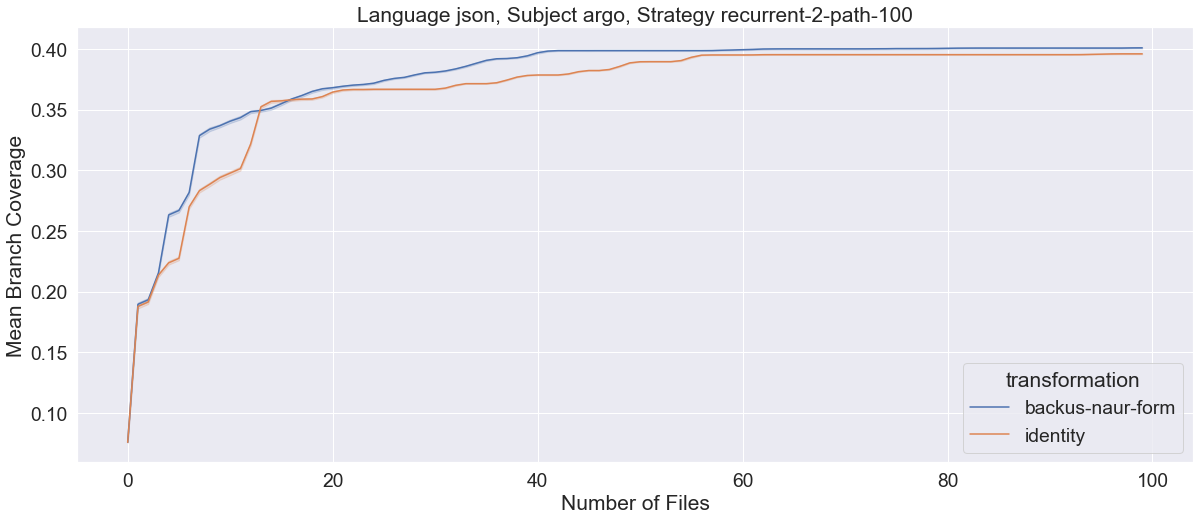

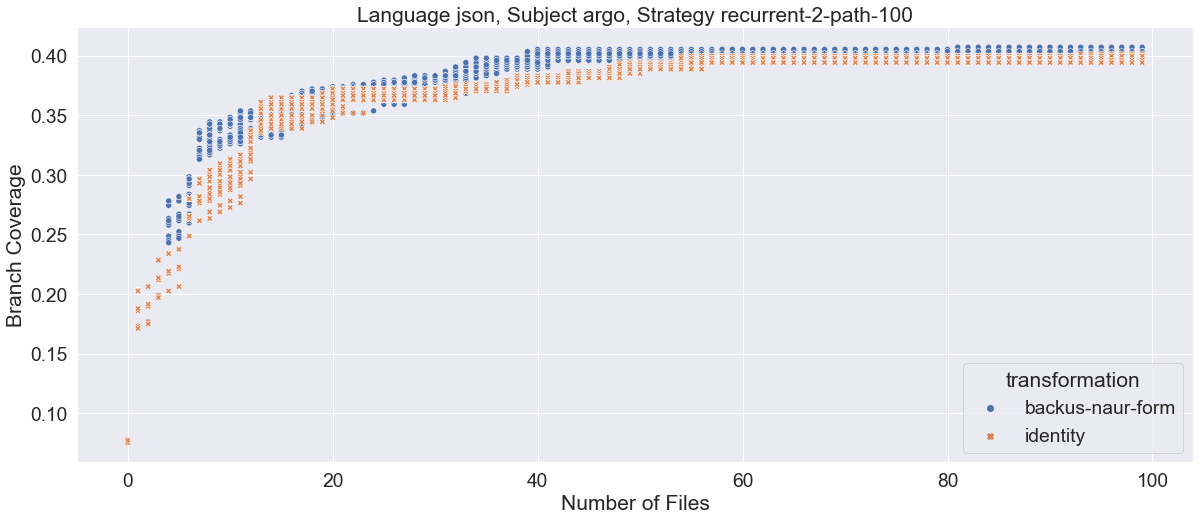

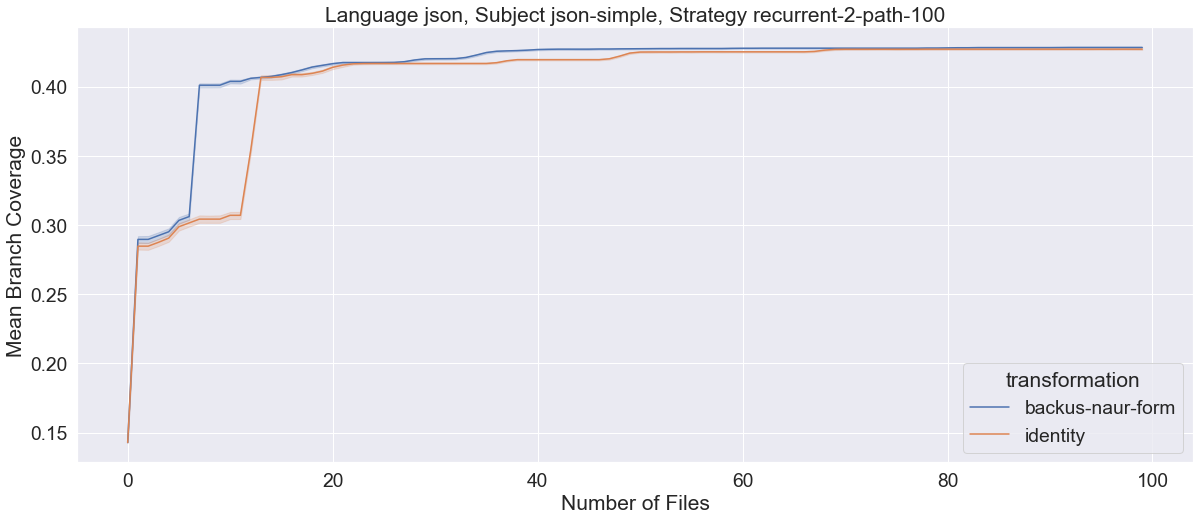

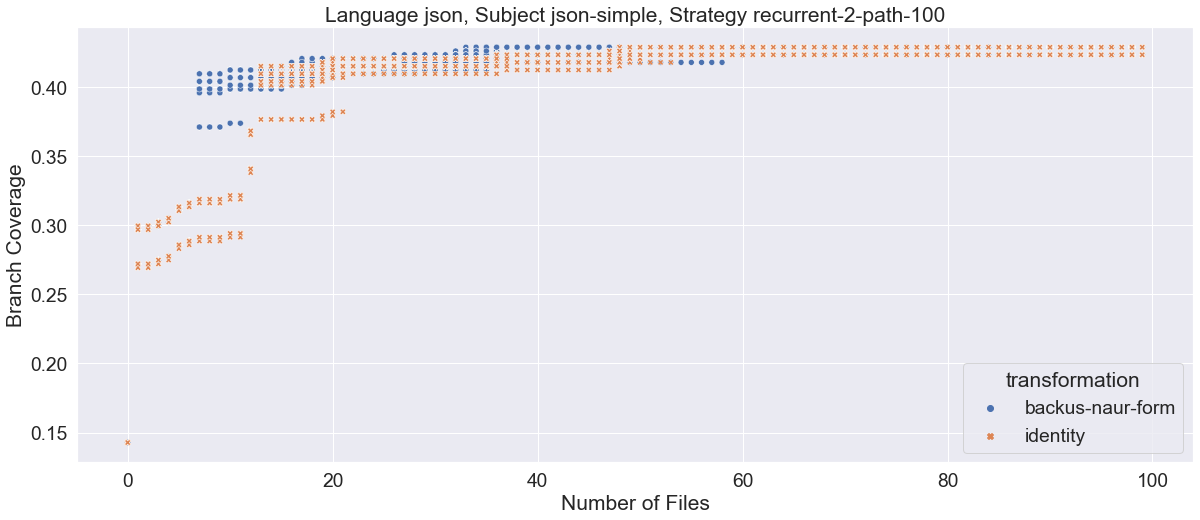

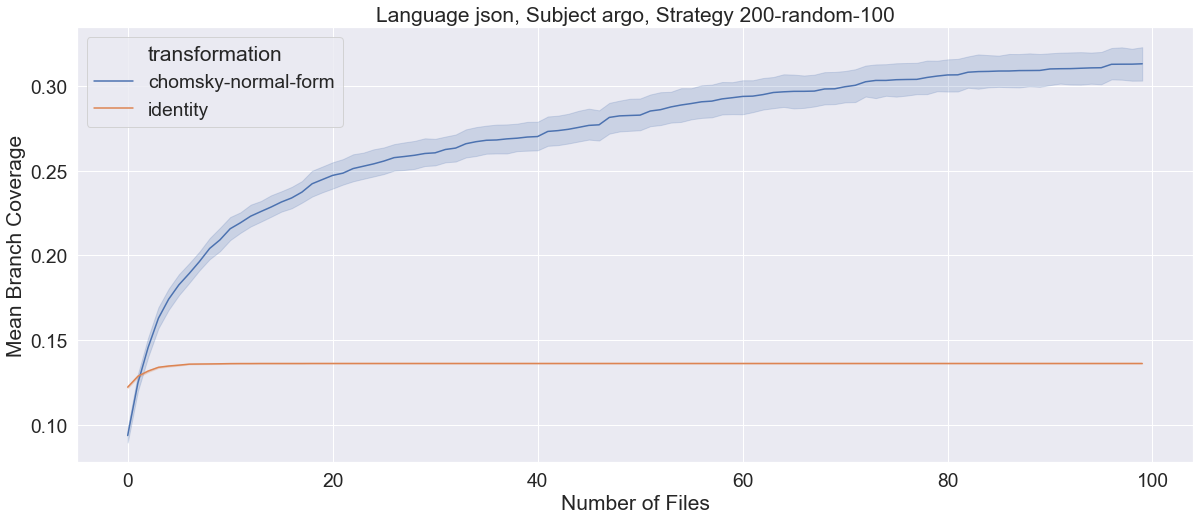

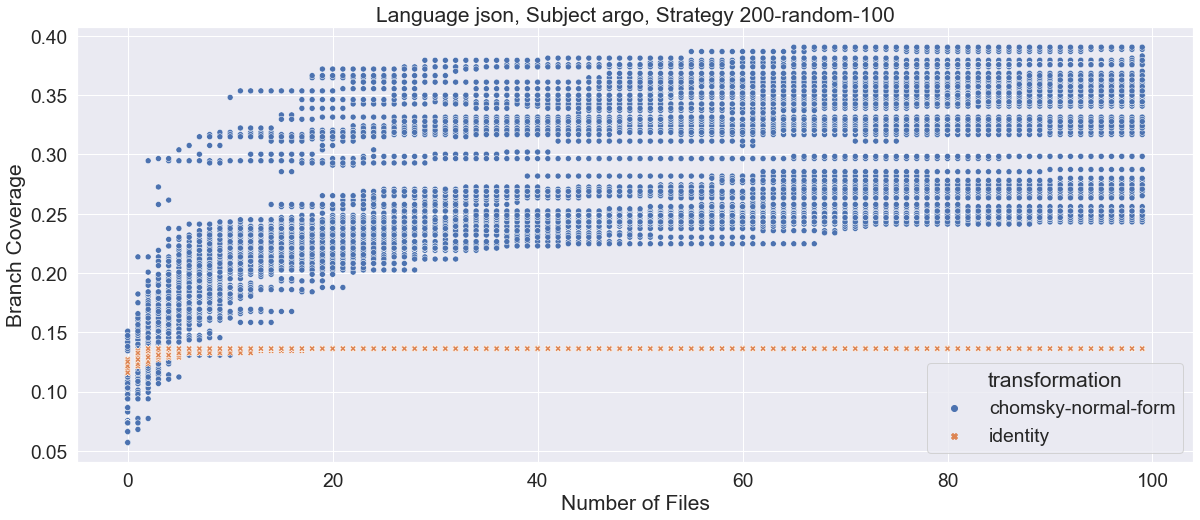

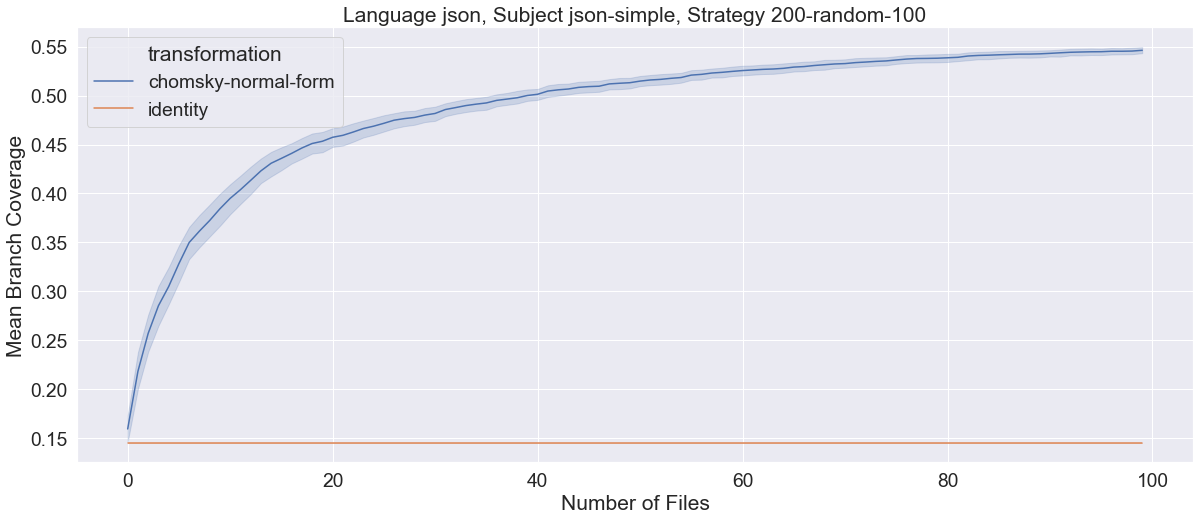

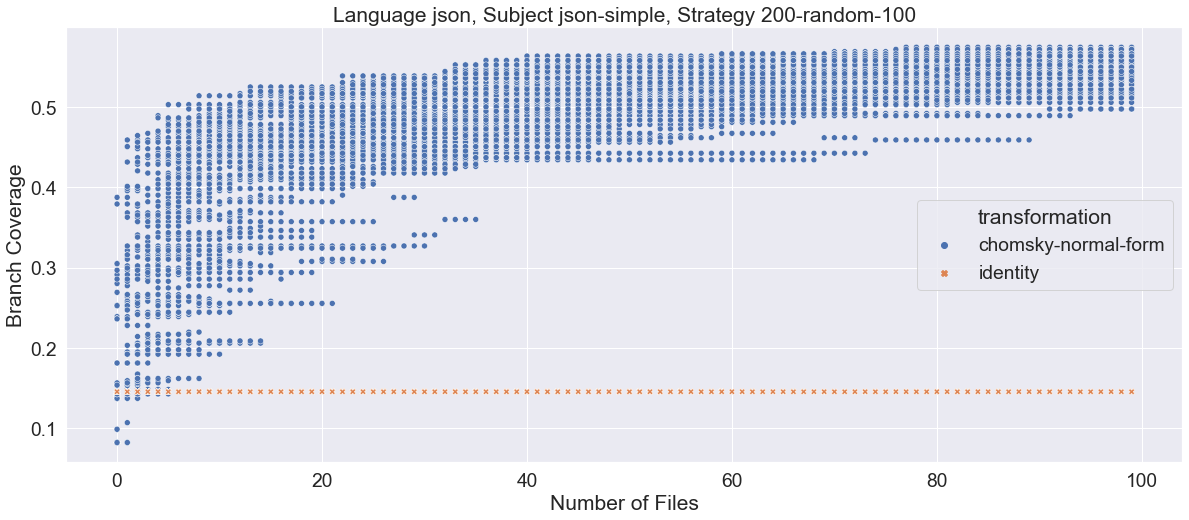

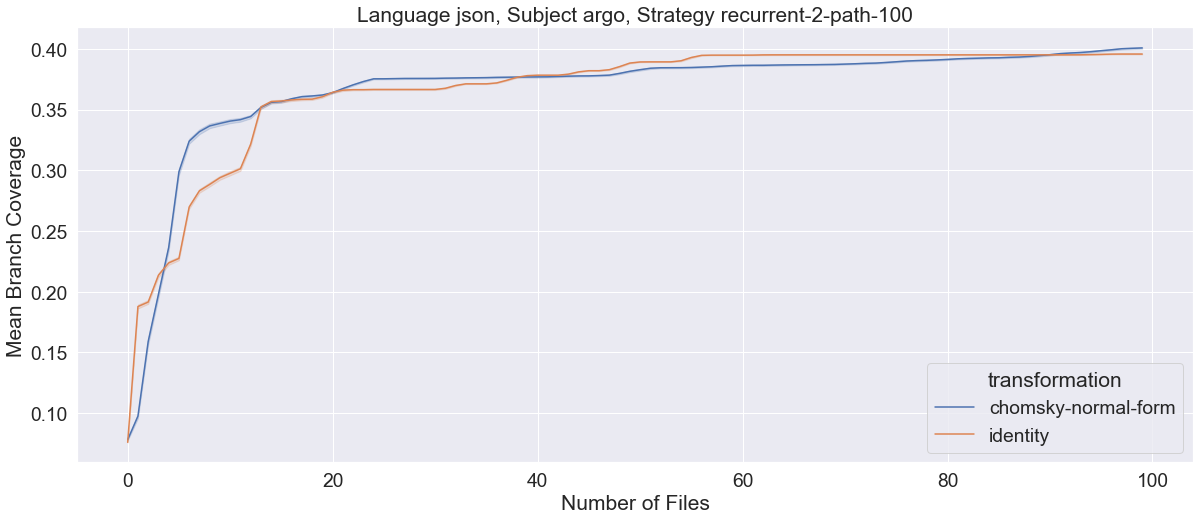

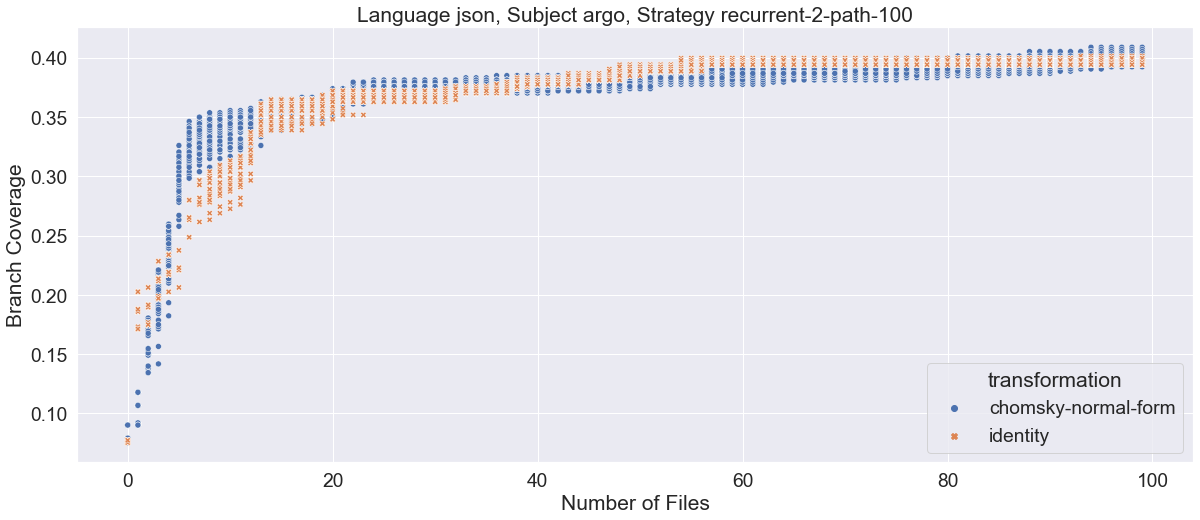

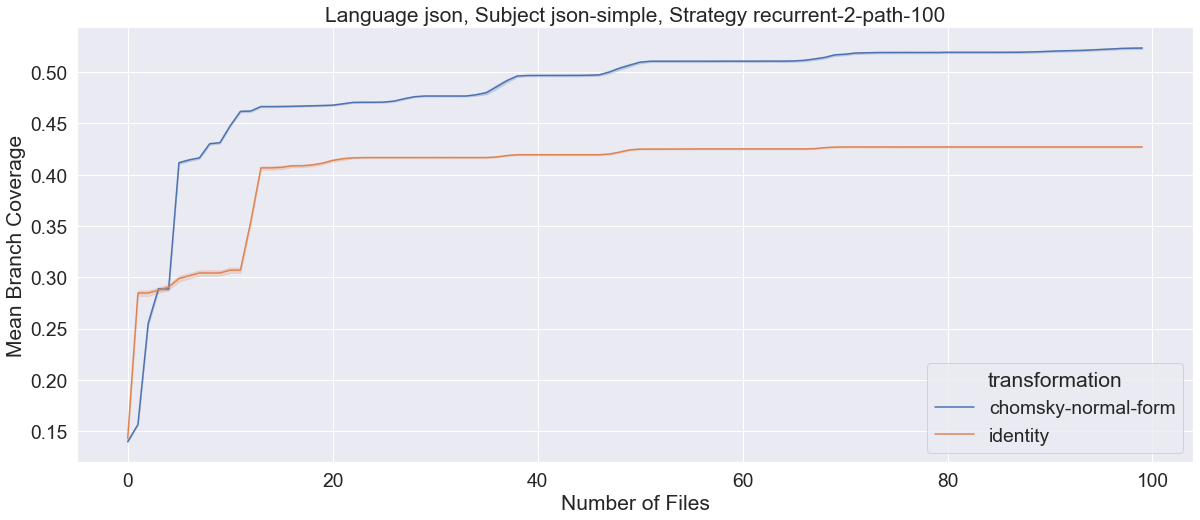

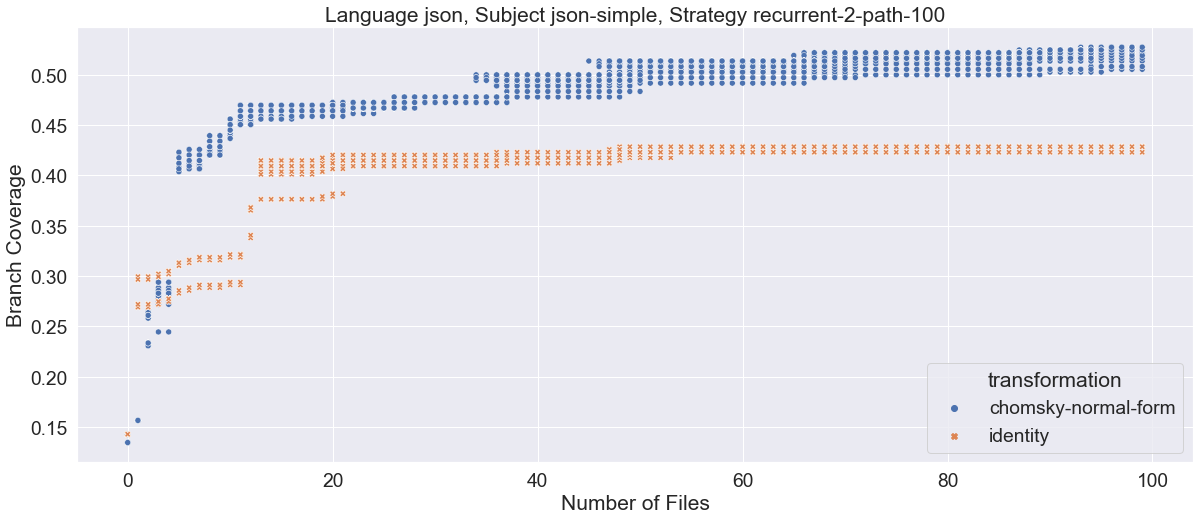

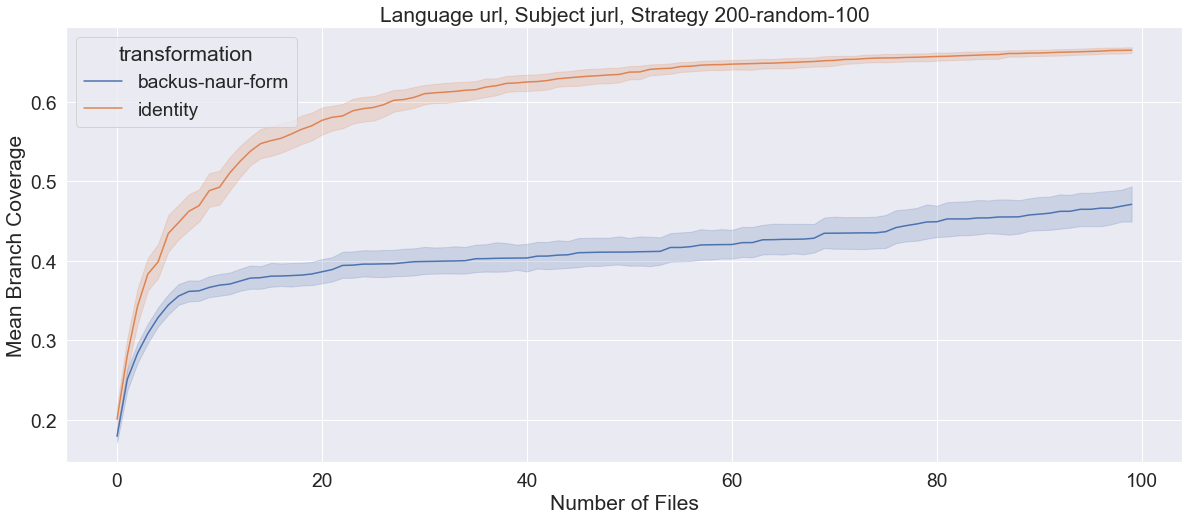

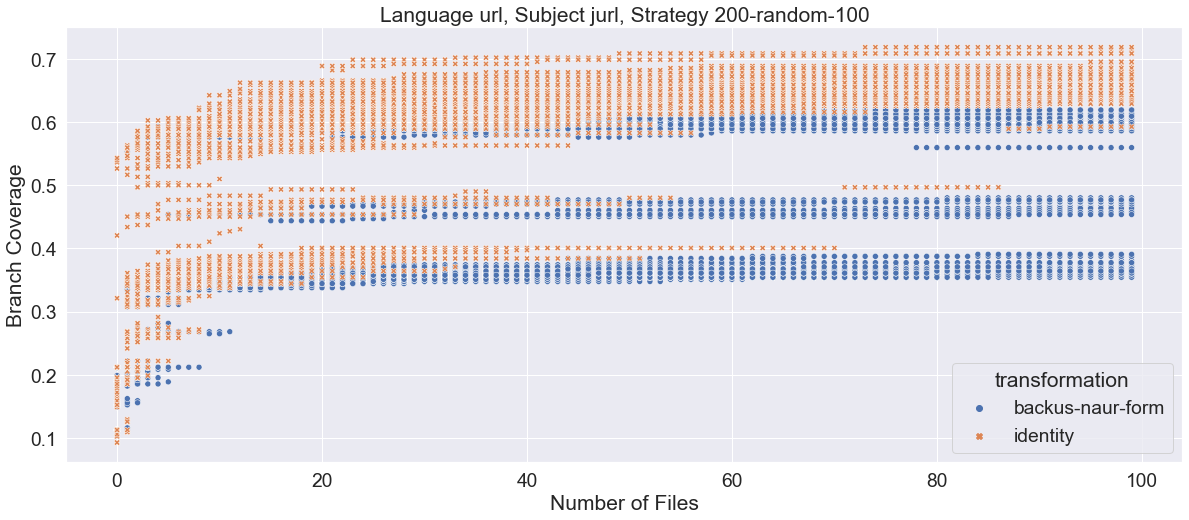

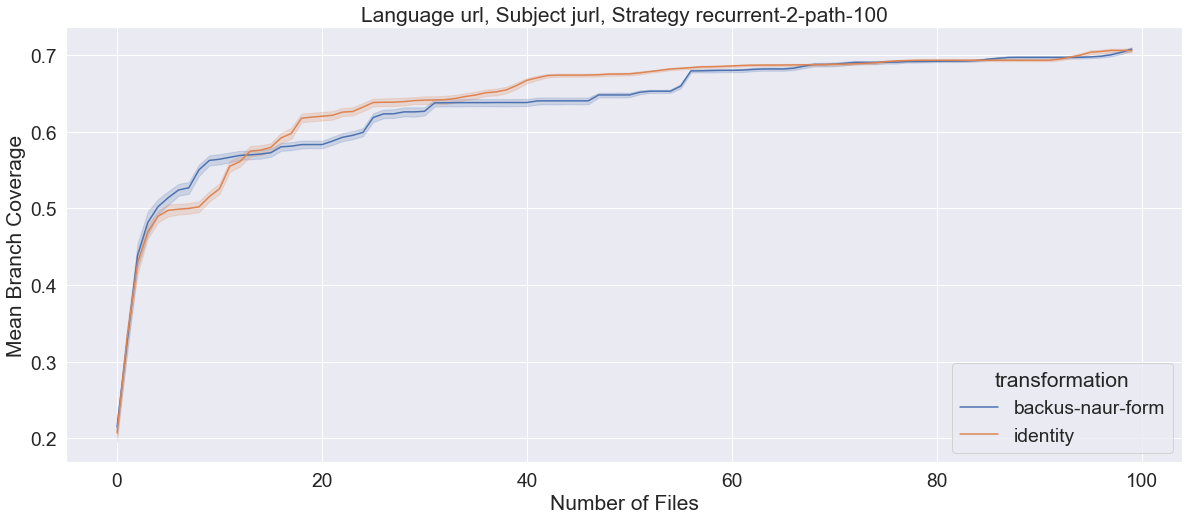

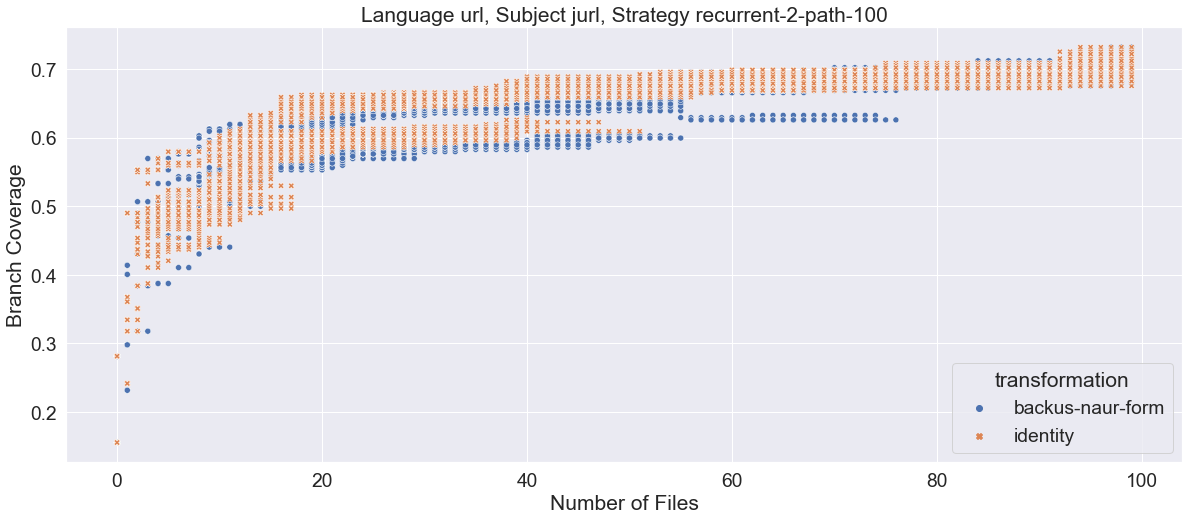

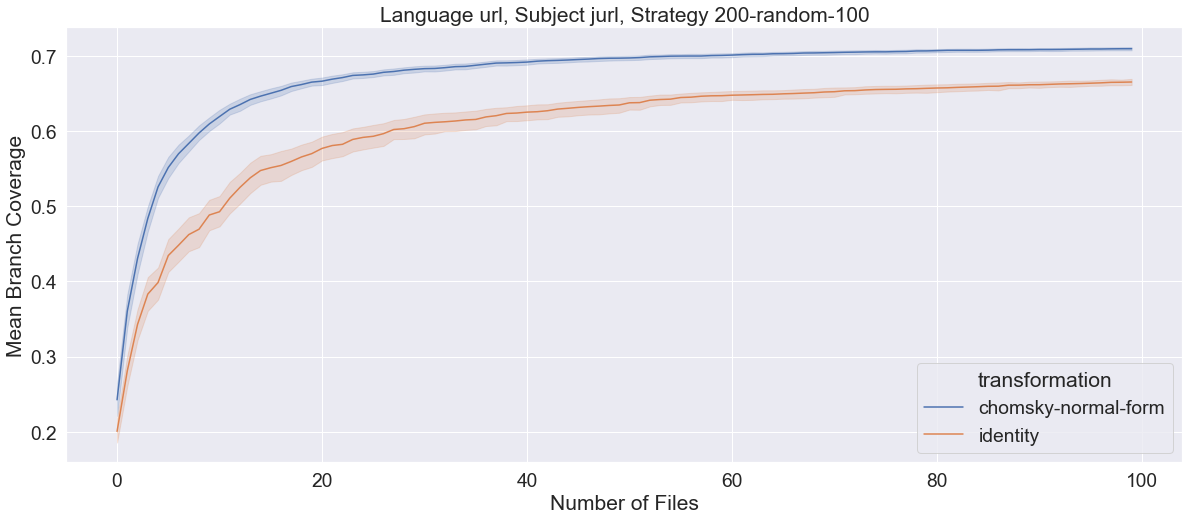

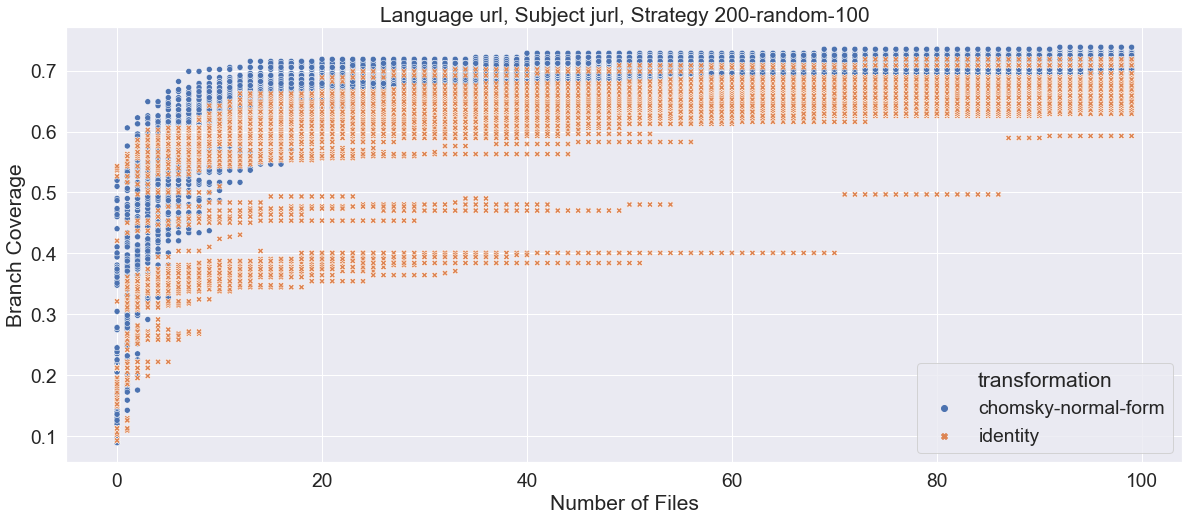

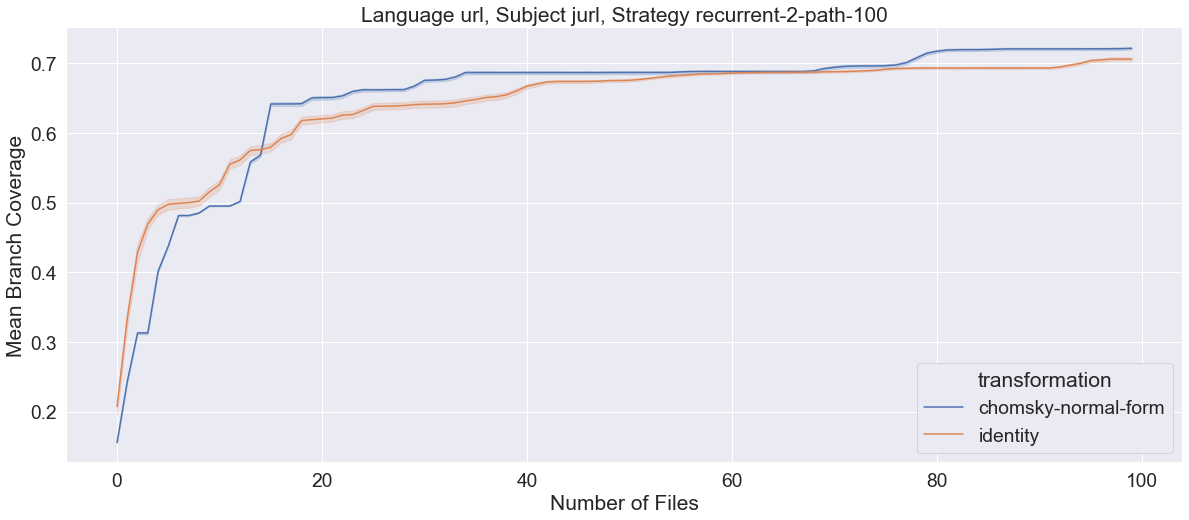

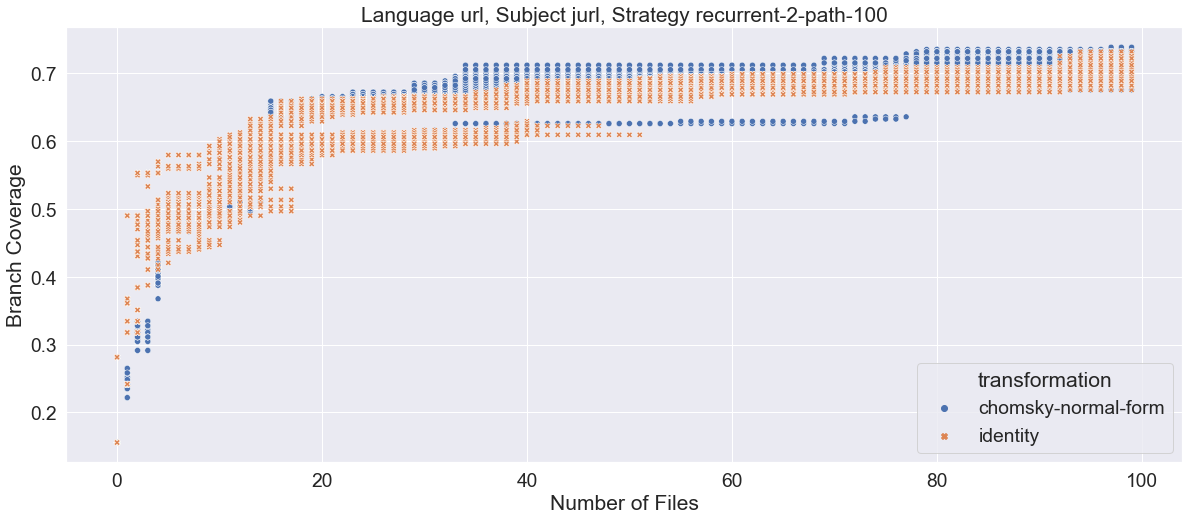

In [19]:
for plotter in plotters:
    plotter.plot_mean_coverage_comparison()
    plotter.plot_scatter_coverage_comparison()

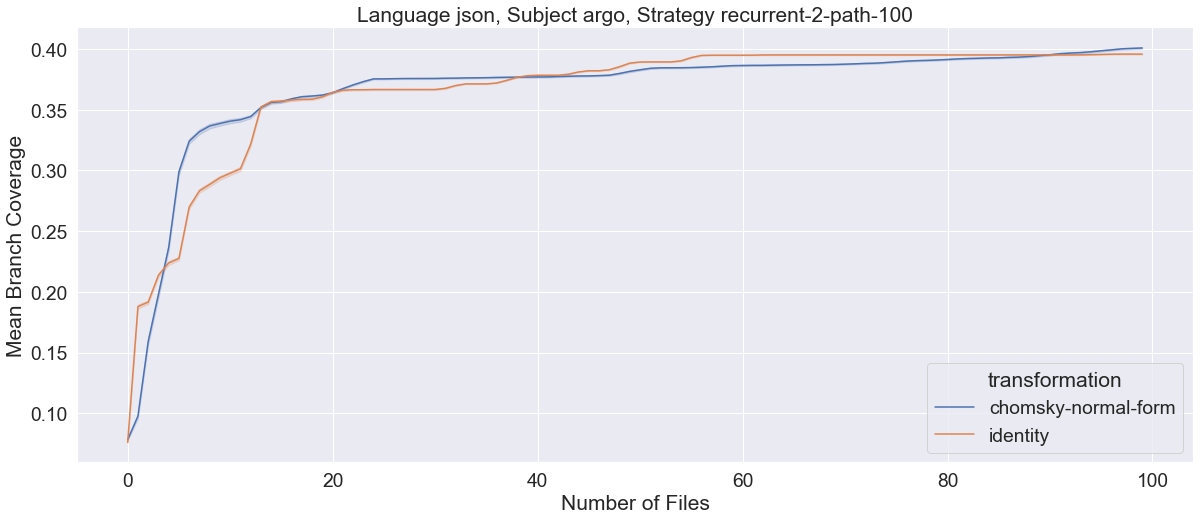

In [23]:
plotter.plot_mean_coverage_comparison()

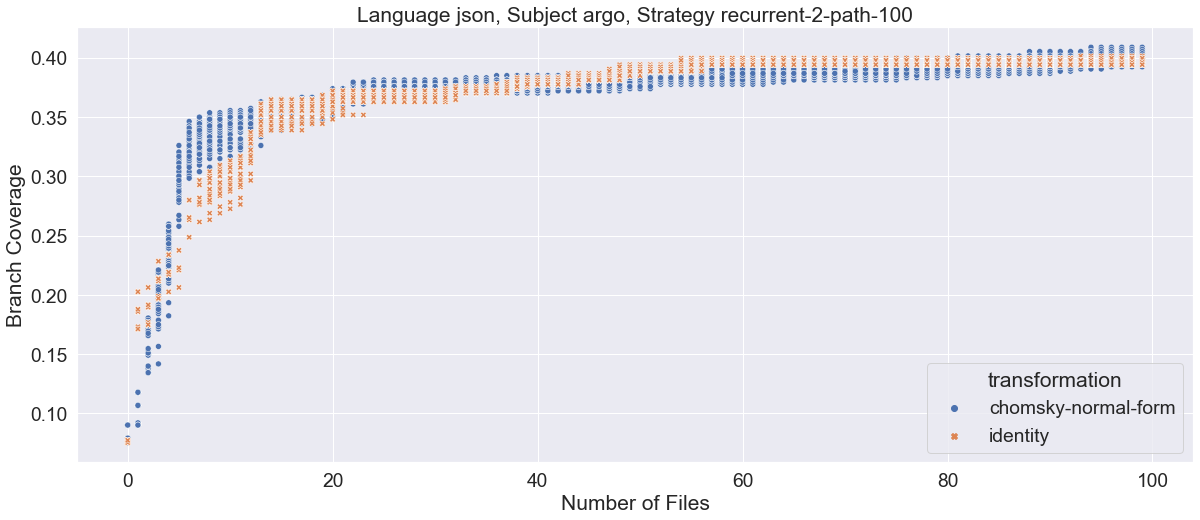

In [24]:
plotter.plot_scatter_coverage_comparison()